# This notebook analyses data from Bpod.

## Tested on output of protocol 'Two_Alternative_Choice'

***
** Import stuff and select animals **
***

In [47]:
%load_ext autoreload
%autoreload 2
from utils import plot_utils, Lapse_model
from utils import custom_functions as cuf

import os
import sys
#sys.path.append("../") # go to parent 
from OpenEphys_Analysis.utils.custom_functions import update_progress
import glob
import ntpath
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import math
import seaborn as sns
import pandas as pd
import warnings
from itertools import chain

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# output a list of animals ready to pull
# Task
BpodProtocol = '/Two_Alternative_Choice/'
# Behavioural data
GeneralDirectory = '/mnt/c/Users/herny/Desktop/SWC/Data/Behavioural_Data/Bpod_data/'

All_Animals = []
for AnimalID in os.listdir(GeneralDirectory):
    DFfile = GeneralDirectory + AnimalID + BpodProtocol + 'Data_Analysis/' + AnimalID + '_dataframe.pkl'
    if os.path.exists(DFfile):
        print('Found data for ' + AnimalID)
        All_Animals.append(AnimalID)


Found data for C01
Found data for C02
Found data for C03
Found data for C04
Found data for C05
Found data for C06
Found data for DRD101
Found data for DRD102
Found data for DRD103
Found data for DRD104
Found data for DRD105
Found data for DRD106
Found data for DRD107
Found data for DRD108
Found data for N01
Found data for N02
Found data for N03
Found data for N05
Found data for N06
Found data for Os01
Found data for Os03
Found data for Ot01
Found data for Ot02
Found data for Ot03
Found data for pdyn01
Found data for pdyn02
Found data for pdyn03
Found data for pdyn04
Found data for Somcre01
Found data for Somcre04
Found data for Somcre05
Found data for Somcre06
Found data for Somcre07
Found data for Somcre08
Found data for Somcre09
Found data for SomFlp01
Found data for SomFlp02
Found data for SomFlp03
Found data for T01
Found data for T03


In [4]:
# Select animals to analyze
#AnimalIDList = ['C01', 'C02', 'C03', 'Ot01', 'Ot02', 'Ot03', 'Os02', 'Os03']
#AnimalIDList = ['C01', 'C02', 'C03', 'N01', 'N02', 'N03', 'N05']
#AnimalIDList = ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'N06']
#AnimalIDList = ['Ot01', 'Ot02', 'Ot03']
AnimalIDList = ['C01','C02','C03','C04','C05','C06',
                'DRD101','DRD102','DRD103','DRD104','DRD105','DRD106','DRD107','DRD108',
                'N01','N02','N03','N05','N06',
                'pdyn01','pdyn02','pdyn03','pdyn04',
                'Somcre01','Somcre04','Somcre05','Somcre06','Somcre07','Somcre08','Somcre09',
                'SomFlp01','SomFlp02','SomFlp03']

# Create out directory if it does not exist
outputDir = GeneralDirectory + '-'.join(AnimalIDList) + '_Analysis/'
if not os.path.isdir(outputDir):
    os.mkdir(outputDir)

In [ ]:
# Read the dataframes and merge them
DataFrames = []
for AnimalID in AnimalIDList:
    DFfile = GeneralDirectory + AnimalID + BpodProtocol + 'Data_Analysis/' + AnimalID + '_dataframe.pkl'
    AnimalDF = pd.read_pickle(DFfile)
    DataFrames.append(AnimalDF)
AnimalsDF = pd.concat(DataFrames, ignore_index=True)

In [11]:
# Create a unique ID for every session
def mergeStrings(df):
    return df['AnimalID'] + ' ' + df['SessionTime']

AnimalsDF['SessionID'] = AnimalsDF[['AnimalID', 'SessionTime']].apply(mergeStrings, axis=1)

In [12]:
# Create a cumulative trial number for every animal BE AWARE THAT SESSIONS MIGHT HAVE BEEN REMOVED BEFORE SO THIS NUMBER IS NOT EXACT
CumTrialsList = []
for Aid in pd.unique(AnimalsDF['AnimalID']):
    CumTrialsList.append(np.arange(len(AnimalsDF[AnimalsDF['AnimalID']==Aid])) + 1)
# flatten the list of lists
AnimalsDF['CumulativeTrialNumber'] = np.array(list(chain(*[x for x in CumTrialsList])))

In [13]:
# Save the dataframe
AnimalsDF.to_pickle(outputDir + '-'.join(AnimalIDList) + '_dataframe.pkl')

In [56]:
# Read the dataframe
AnimalsDF = pd.read_pickle(outputDir + '-'.join(AnimalIDList) + '_dataframe.pkl')

In [7]:
pd.unique(AnimalsDF.ExperimentalGroup)

array(['CortexBuffer', '6OHDAtail', 'Drd1tailKO', 'NMDAtail', 'Control',
       'ToSprojecting-BLAcaspase'], dtype=object)

In [31]:
# plot the behavioral performance on the easy trials as a function of trials


***
#### Get a summary of all the mice in the dataset

Progress: [####################] 100.0%


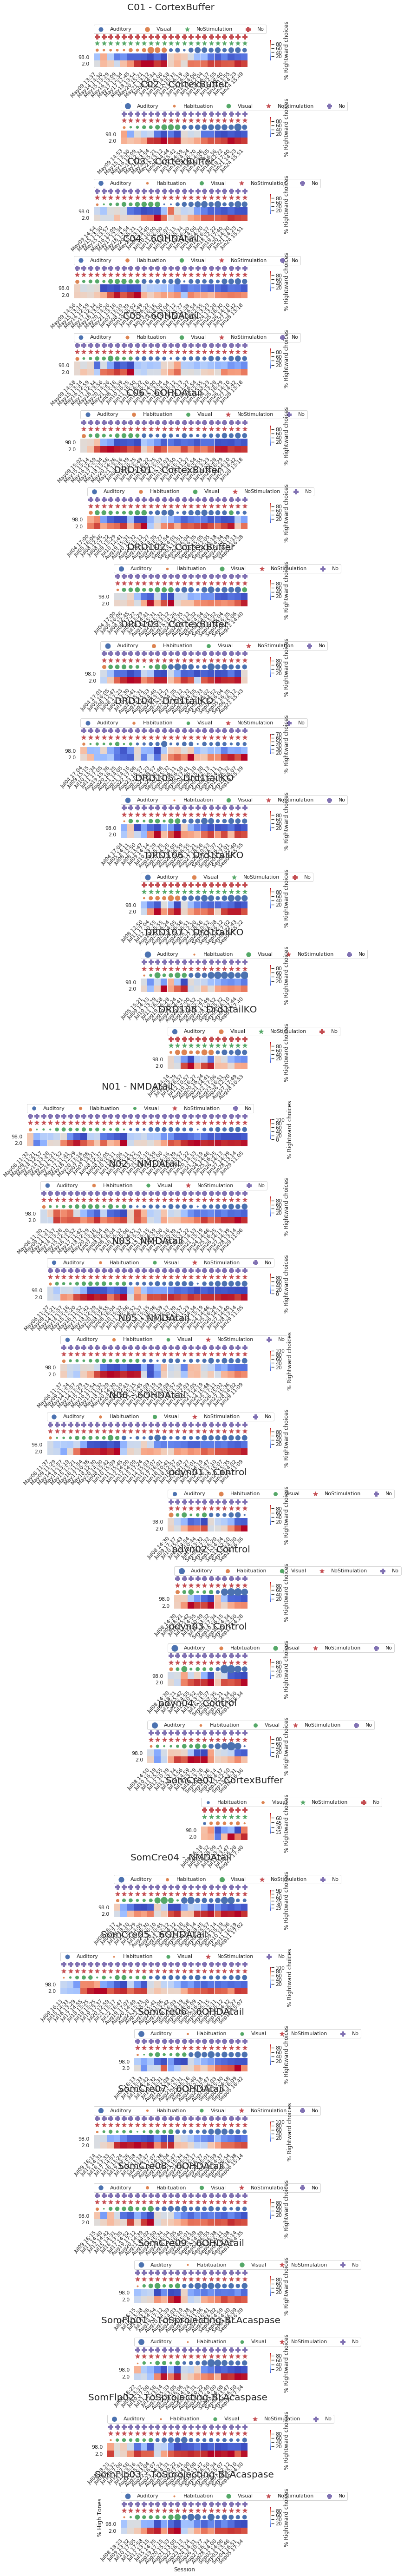

In [57]:
# plot it THIS NEEDS TO BE IMPROVED
fig, ax = plt.subplots(len(pd.unique(AnimalsDF.AnimalID)), 1, figsize=(17,3 * len(pd.unique(AnimalsDF.AnimalID))))
axs = ax.ravel()
fig.subplots_adjust(hspace=1.3)
for i, animal in enumerate(pd.unique(AnimalsDF.AnimalID)):
    animalDF = AnimalsDF[AnimalsDF.AnimalID == animal]
    dfToPlot = plot_utils.summary_matrix(animalDF)
    axs[i] = plot_utils.summary_plot(dfToPlot, animalDF, axs[i])
    
#plt.savefig(outputDir + AnimalID + '_psychometricPerformanceAllSessionsHeatmap.pdf', transparent=True,dpi = 500, bbox_inches='tight')
plt.show(fig)

***
**Plot the evolution of the cumulative performance**
***

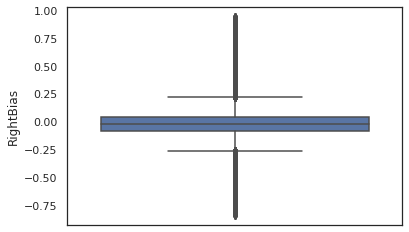

In [59]:
# Calculate the right bias
AnimalsDF['RightBias'] = cuf.CalculateRBiasWindow(np.array(AnimalsDF['FirstPoke']),\
                                                              np.array(AnimalsDF['FirstPokeCorrect']), 50)

sns.boxplot(y='RightBias', data=AnimalsDF)

In [60]:
#Select conditions

# include only the easy trials
condition1 = np.logical_or(AnimalsDF['TrialSequence']==1, AnimalsDF['TrialSequence']==7)
# include only trials without stimulation
condition2 = AnimalsDF['OptoStim'] == 0
# remove trials in which the animal is too biased
RBlimit = 1
condition3 = np.logical_and(AnimalsDF['RightBias']>(-RBlimit), AnimalsDF['RightBias']<(RBlimit))

conditions = np.logical_and(np.logical_and(condition1, condition2), condition3)

In [61]:
AnimalsDF[conditions].describe()

,CenterPortDuration,Contingency,RewardAmount,TrialIndex,TrialHighPerc,Outcomes,OptoStim,FirstPokeCorrect,FirstPoke,TrialSide,TrialSequence,ResponseTime,TrialStartTimestamp,CumulativePerformance,SwitchSide,PreviousChoice,CumulativeTrialNumber,RightBias
count,271361.000000,271361.0,271361.000000,271361.000000,271361.000000,271361.000000,271361.0,268624.000000,268624.000000,271361.000000,271361.000000,271361.000000,271361.000000,271289.000000,271361.000000,268046.000000,271361.000000,271361.000000
mean,0.101926,1.0,2.227033,262.821408,49.429188,0.833499,0.0,0.776096,1.493575,1.505946,4.035676,0.579529,1602.255007,75.683018,0.485221,1.493665,4346.586706,-0.012895
std,0.019531,0.0,0.490246,212.385758,47.996694,0.446427,0.0,0.416859,0.499960,0.499966,2.999793,1.807239,1257.894874,17.629393,0.499782,0.499961,2654.168256,0.149660
min,0.100000,1.0,2.000000,0.000000,2.000000,0.000000,0.0,0.000000,1.000000,1.000000,1.000000,0.039900,1.983500,0.000000,0.000000,1.000000,1.000000,-0.840000
25%,0.100000,1.0,2.000000,101.000000,2.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.216800,647.062000,60.000000,0.000000,1.000000,2080.000000,-0.080000
50%,0.100000,1.0,2.000000,215.000000,2.000000,1.000000,0.0,1.000000,1.000000,2.000000,7.000000,0.277700,1266.418700,79.598145,0.000000,1.000000,4207.000000,-0.020000
75%,0.100000,1.0,2.000000,371.000000,98.000000,1.000000,0.0,1.000000,2.000000,2.000000,7.000000,0.412000,2261.120100,91.379310,1.000000,2.000000,6426.000000,0.040000
max,0.300000,1.0,5.000000,1430.000000,98.000000,3.000000,0.0,1.000000,2.000000,2.000000,7.000000,30.000000,10483.370000,100.000000,1.000000,2.000000,10596.000000,0.940000


In [62]:
# Calculate the performance based on these trials only
EasyDF = AnimalsDF[conditions]

# calculate the cumulative performance
def CumPerCalculator(df):
    firstpokecorrect = df['FirstPokeCorrect']
    correct_cp = np.cumsum(firstpokecorrect == 1)
    incorrect_cp = np.cumsum(firstpokecorrect == 0)
    cumper = 100 * correct_cp / (correct_cp + incorrect_cp)
    return cumper

CumPerList = []
for Sid in pd.unique(EasyDF['SessionID']):
    CumPerList.append(CumPerCalculator(EasyDF[EasyDF['SessionID']==Sid]))
# flatten the list of lists
EasyDF['CumulativePerformance'] = np.array(list(chain(*[x for x in CumPerList])))


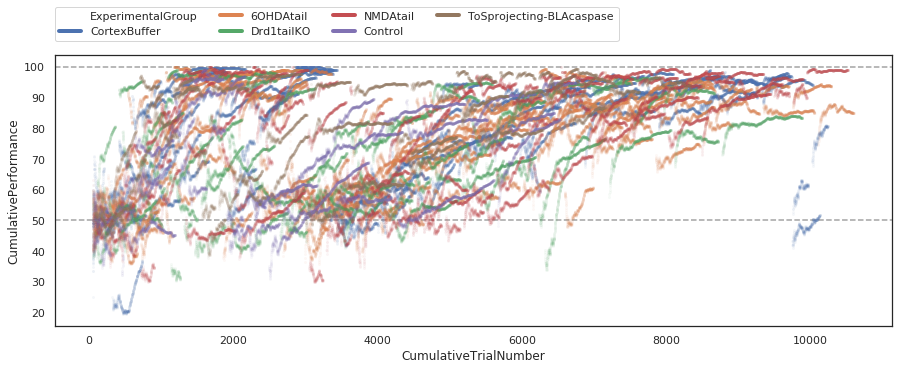

In [64]:
# remove the trials at the beginning of the session because it makes it noisy
condition4 = EasyDF['TrialIndex'] > 50

# remove the Aud_Psycho
condition5 = ~(EasyDF['Protocol'] == 'Aud_Psycho')

fig, ax = plt.subplots(figsize=(15,5))
ax.axhline(50, ls='--', alpha=0.4, color='k')
ax.axhline(100, ls='--', alpha=0.4, color='k')
sns.lineplot(x='CumulativeTrialNumber', y='CumulativePerformance', data=EasyDF[np.logical_and(condition4, condition5)],
             hue='ExperimentalGroup', marker=".", alpha=0.05, markeredgewidth=0, linewidth=0,
             units="AnimalID", estimator=None)

lgd = plt.legend(ncol=4, loc=(0,1.05), borderaxespad=0.)
for l in lgd.get_lines():
    l.set_alpha(1)
    l.set_linewidth(4)

plt.savefig(outputDir + 'CumulativePerformance.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [65]:
# Restart the count of CumulativeTrialNumber for every protocol and plot in different rows sharing x axis
EasyDF['CumulativeTrialNumberByProtocol'] = np.nan

for Aid in pd.unique(EasyDF['AnimalID']):
    for Prot in pd.unique(EasyDF['Protocol']):
        conditions = np.logical_and(EasyDF['AnimalID']==Aid, EasyDF['Protocol']==Prot)
        EasyDF.CumulativeTrialNumberByProtocol.loc[EasyDF[conditions].index] = \
        np.arange(len(EasyDF[conditions])) + 1
            

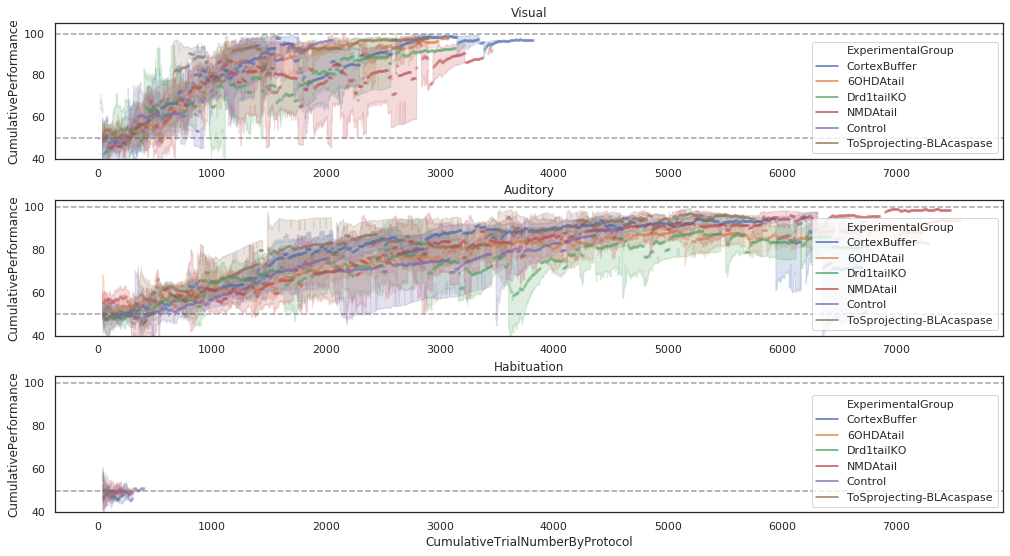

In [68]:
# remove the trials at the beginning of the session because it makes it noisy
condition4 = EasyDF['TrialIndex'] > 40

fig, axs = plt.subplots(len(pd.unique(EasyDF['Protocol'])), 1, figsize=(17,3 * len(pd.unique(EasyDF['Protocol']))), sharex=True)
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.3)
for ax in axs:
    ax.axhline(50, ls='--', alpha=0.4, color='k')
    ax.axhline(100, ls='--', alpha=0.4, color='k')

for ax, prot in enumerate(pd.unique(EasyDF['Protocol'])):
    sns.lineplot(x='CumulativeTrialNumberByProtocol', y='CumulativePerformance',
                 data=EasyDF[np.logical_and(condition4, EasyDF['Protocol']==prot)],
                 ax=axs[ax], hue='ExperimentalGroup', 
                 marker=".", alpha=0.05, markeredgewidth=0, linewidth=0)
                 # the following line splits the data and does not compute confidence intervals and mean
                 #units="AnimalID", estimator=None)
                
    axs[ax].set_title(prot)
    axs[ax].set_ylim(bottom=40)
    '''
    lgd = axs[ax].legend(ncol=4, loc=(0,1.05), borderaxespad=0.)
    for l in lgd.get_lines():
        l.set_alpha(1)
        l.set_linewidth(4)
    '''
for ax in axs:
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
        
plt.savefig(outputDir + 'CumulativePerformanceByProtocol_Group.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [70]:
pd.unique(AnimalsDF.AnimalID)

array(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'DRD101', 'DRD102',
       'DRD103', 'DRD104', 'DRD105', 'DRD106', 'DRD107', 'DRD108', 'N01',
       'N02', 'N03', 'N05', 'N06', 'pdyn01', 'pdyn02', 'pdyn03', 'pdyn04',
       'SomCre01', 'SomCre04', 'SomCre05', 'SomCre06', 'SomCre07',
       'SomCre08', 'SomCre09', 'SomFlp01', 'SomFlp02', 'SomFlp03'],
      dtype=object)

Create a simpler plot calculating the performance of the day


In [39]:
# Day of training
def getDay(df):
    return df.SessionTime.split(' ')[0]
    
AnimalsDF['TrainingDay'] = AnimalsDF.apply(getDay, axis=1)

In [40]:
# generate a new dataset to get the data
dfForPlot = custom_functions.AnalyzePercentageByDay(AnimalsDF)

In [16]:
# DEPRECATED *****

# Make a column with the group each mouse is in


def AssignToGroup(df):
    # Copy the AnimalIDList
    #AnimalIDList = ['C01', 'C02', 'C03', 'N01', 'N02', 'N03', 'N05']
    AnimalIDList = ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'N06']
    # Create a vector here that is like the AnimalIDList
    #AnimalGroup = ['CortexBuffer', 'CortexBuffer', 'CortexBuffer', 'NMDA', 'NMDA', 'NMDA', 'NMDA']
    AnimalGroup = ['CortexBuffer', 'CortexBuffer', 'CortexBuffer', '6OHDA', '6OHDA', '6OHDA', '6OHDA']
    # Index position
    IndxPos = AnimalIDList.index(df['AnimalID'])
    return AnimalGroup[IndxPos]



AnimalsDF['Injection'] = AnimalsDF.apply(AssignToGroup, axis=1)

In [41]:
dfForPlot

,AnimalID,Injection,PercCorrect,Protocol,SessionTime
0,C01,CortexBuffer,51.265823,Visual,May09
1,C01,CortexBuffer,42.696629,Visual,May14
2,C01,CortexBuffer,59.813084,Visual,May15
3,C01,CortexBuffer,59.130435,Visual,May16
4,C01,CortexBuffer,80.653951,Visual,May17
5,C01,CortexBuffer,94.339623,Visual,May18
6,C01,CortexBuffer,96.815287,Visual,May20
7,C01,CortexBuffer,99.070848,Visual,May21
8,C01,CortexBuffer,91.981132,Visual,Jun08
9,C01,CortexBuffer,98.249027,Visual,Jun10


In [42]:
# For each animal and protocol, calculate the session count for that protocol
# ProtocolCount
dfForPlot['ProtocolCount'] = np.nan
for animal in pd.unique(dfForPlot['AnimalID']):
    for protocol in pd.unique(dfForPlot['Protocol']):
        conditions = np.logical_and(dfForPlot['AnimalID']==animal, dfForPlot['Protocol']==protocol)
        dfForPlot.ProtocolCount.loc[dfForPlot[conditions].index] = \
        np.arange(len(dfForPlot[conditions])) + 1

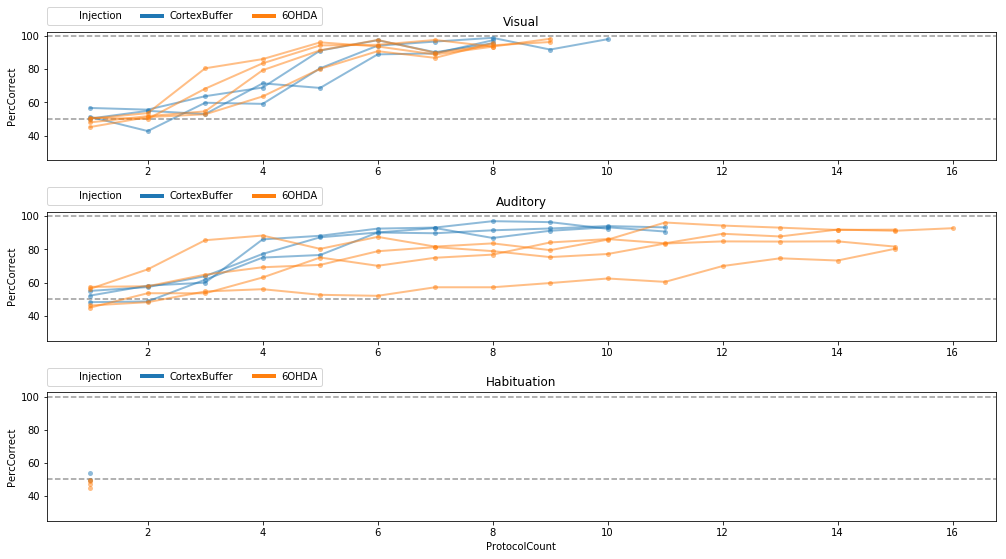

In [43]:
fig, axs = plt.subplots(len(np.unique(dfForPlot['Protocol'])),1, figsize=(17,3*len(np.unique(dfForPlot['Protocol']))), sharex=True)
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.4)
for ax in axs:
    ax.axhline(50, ls='--', alpha=0.4, color='k')
    ax.axhline(100, ls='--', alpha=0.4, color='k')

for ax, prot in enumerate(pd.unique(dfForPlot['Protocol'])):
    sns.lineplot(x='ProtocolCount', y='PercCorrect',
                 data=dfForPlot[dfForPlot['Protocol']==prot],
                 ax=axs[ax], hue='Injection', 
                 marker=".", alpha=0.5, markeredgewidth=0, linewidth=2, markersize=10,
                 # the following line splits the data and does not compute confidence intervals and mean
                 units="AnimalID", estimator=None)
                
    axs[ax].set_title(prot)
    axs[ax].set_ylim(bottom=25)
    
    lgd = axs[ax].legend(ncol=4, loc=(0,1.05), borderaxespad=0.)
    for l in lgd.get_lines():
        l.set_alpha(1)
        l.set_linewidth(4)
    
for ax in axs:
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
        
plt.savefig(outputDir + 'SessionPercCorrectByProtocol.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

#sns.barplot(x='SessionTime', y='PercCorrect', hue='AnimalID', data=dfForPlot)

#### Analyze specific sessions

In [31]:
# Group sessions by type
protToGroup = 'Aud_Psycho'
stimToGroup = 'Right'
pulledData = AnimalsDF[(AnimalsDF['Protocol']==protToGroup) & (AnimalsDF['Stimulation']==stimToGroup)]

PlotsTitle = protToGroup + '_' + stimToGroup


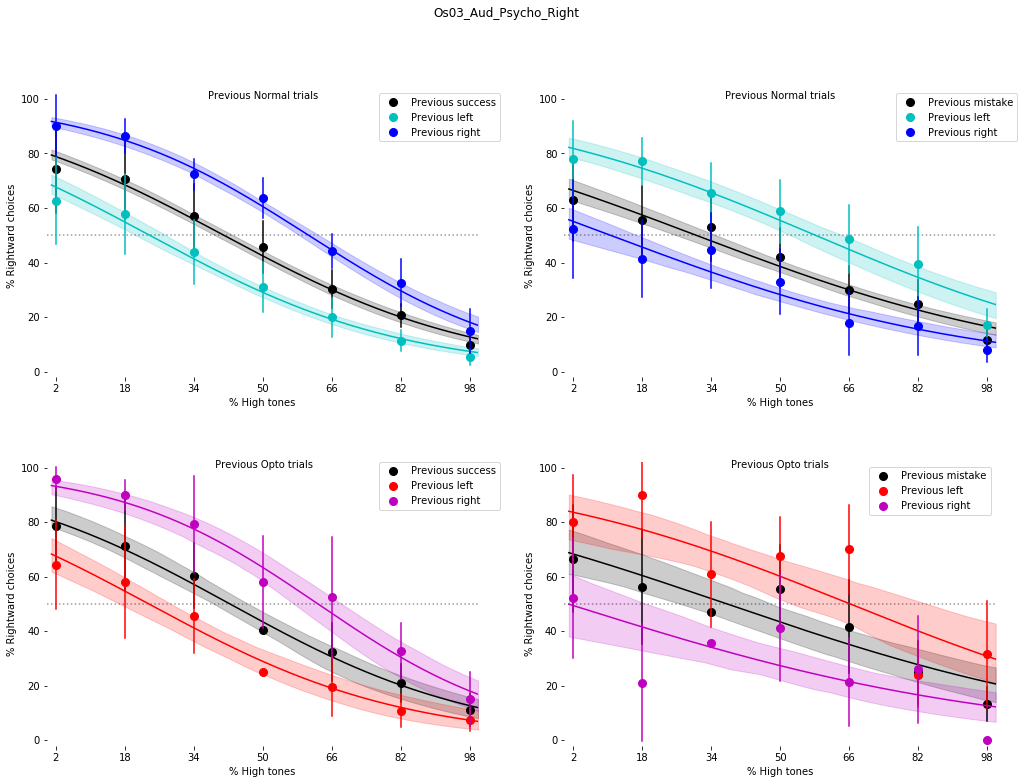

In [32]:
# Check responses to where the previous trial was (L or R) and previous success
PrevTrialSuccess = np.insert(np.array(pulledData['FirstPokeCorrect'][:-1]), 0, np.nan)
PrevTrialSide = np.insert(np.array(pulledData['TrialSide'][:-1]), 0, np.nan)
PrevOptoCondition = np.insert(np.array(pulledData['OptoStim'][:-1]), 0, np.nan)
# generate a list of the conditions, colors and labels
CondList = [(PrevOptoCondition==0) & (PrevTrialSuccess==1),
            (PrevOptoCondition==0) & (PrevTrialSuccess==1) & (PrevTrialSide==1),
            (PrevOptoCondition==0) & (PrevTrialSuccess==1) & (PrevTrialSide==2),
            (PrevOptoCondition==0) & (PrevTrialSuccess==0),
            (PrevOptoCondition==0) & (PrevTrialSuccess==0) & (PrevTrialSide==1),
            (PrevOptoCondition==0) & (PrevTrialSuccess==0) & (PrevTrialSide==2),
            (PrevOptoCondition==1) & (PrevTrialSuccess==1),
            (PrevOptoCondition==1) & (PrevTrialSuccess==1) & (PrevTrialSide==1),
            (PrevOptoCondition==1) & (PrevTrialSuccess==1) & (PrevTrialSide==2),
            (PrevOptoCondition==1) & (PrevTrialSuccess==0),
            (PrevOptoCondition==1) & (PrevTrialSuccess==0) & (PrevTrialSide==1),
            (PrevOptoCondition==1) & (PrevTrialSuccess==0) & (PrevTrialSide==2)]
ColorList = ['k', 'c', 'b', 'k', 'c', 'b','k', 'r', 'm', 'k', 'r', 'm']
LabelList = ['Previous success', 'Previous left', 'Previous right', 'Previous mistake', 'Previous left', 'Previous right',\
             'Previous success', 'Previous left', 'Previous right', 'Previous mistake', 'Previous left', 'Previous right']
AxsOrder = [0,0,0,1,1,1,2,2,2,3,3,3]
SubplotTitles = ['Previous Normal trials', 'Previous Normal trials', ' Previous Opto trials', 'Previous Opto trials',]
# plot
fig, axs = plt.subplots(2,2,figsize=(17, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.3)
for i, ax in enumerate(axs):
    ax.hlines(50, 0, 100, linestyles='dotted' , alpha=0.4)
    ax.text(50,100, SubplotTitles[i], horizontalalignment='center')
for i, condition in enumerate(CondList):
    predictDif, PsyPer, fakePredictions, predictPer, EB =\
    custom_functions.PP_ProcessExperiment(pulledData[condition], 100, error_bars='SessionTime')
    if PsyPer:
        plot_utils.PlotPsychPerformance(dataDif = PsyPer['Difficulty'], dataPerf = PsyPer['Performance'],
                     predictDif = predictDif, ax = axs[AxsOrder[i]], fakePred = fakePredictions,
                     realPred = predictPer, color = ColorList[i], label = LabelList[i], errorBars = EB)
lgd = plt.legend()
plt.suptitle(AnimalID + '_' + protToGroup + '_' + stimToGroup)
plt.show(fig)

In [22]:
pulledData[condition]

,AnimalID,CenterPortDuration,Contingency,CumulativePerformance,FirstPoke,FirstPokeCorrect,OptoStim,Outcomes,PreviousChoice,Protocol,...,SessionTime,Stimulation,SwitchSide,TrialEvents,TrialHighPerc,TrialIndex,TrialSequence,TrialSide,TrialStartTimestamp,TrialStates
8243,Ot03,0.2,1,81.818182,2.0,1.0,0.0,1.0,1.0,Aud_Psycho,...,Apr10 17:04,Right,0,"{'Port2Out': 13.4641, 'Port3In': 13.7342000000...",2.0,54,7.0,2.0,442.8032,"{'Punish': [nan, nan], 'WaitForResponse': [13...."
8622,Ot03,0.2,1,75.483871,1.0,1.0,0.0,1.0,1.0,Aud_Psycho,...,Apr11 15:07,Right,1,"{'Port2Out': 1.5248, 'Tup': [1.304, 1.9156, 1....",82.0,155,2.0,1.0,1310.3586,"{'Punish': [nan, nan], 'WaitForResponse': [1.5..."
8746,Ot03,0.2,1,73.835125,2.0,1.0,0.0,1.0,1.0,Aud_Psycho,...,Apr11 15:07,Right,0,"{'Port2Out': [0.2605, 1.3077999999999999], 'Tu...",18.0,279,6.0,2.0,2399.2494,"{'Punish': [nan, nan], 'WaitForResponse': [1.3..."
8782,Ot03,0.2,1,74.920635,1.0,0.0,0.0,0.0,1.0,Aud_Psycho,...,Apr11 15:07,Right,0,"{'Port2Out': [0.6073, 1.5582], 'Port2In': [0.1...",34.0,315,5.0,2.0,2641.9858,"{'Punish': [0.888, 3.888], 'WaitForResponse': ..."
8794,Ot03,0.2,1,74.617737,1.0,1.0,1.0,1.0,1.0,Aud_Psycho,...,Apr11 15:07,Right,1,"{'Port2Out': 0.7432000000000001, 'Port2In': 0....",82.0,327,2.0,1.0,2704.2392,"{'Punish': [nan, nan], 'WaitForResponse': [0.7..."
8871,Ot03,0.2,1,74.009901,1.0,1.0,0.0,1.0,1.0,Aud_Psycho,...,Apr11 15:07,Right,1,"{'Port2Out': [0.1731, 0.7647], 'Tup': [0.7366,...",98.0,404,1.0,1.0,3130.9387,"{'Punish': [nan, nan], 'WaitForResponse': [0.7..."
8937,Ot03,0.2,1,73.617021,2.0,0.0,1.0,0.0,1.0,Aud_Psycho,...,Apr11 15:07,Right,1,"{'Port2Out': [0.129, 0.3712, 1.4578, 2.2376], ...",82.0,470,2.0,1.0,3526.9308,"{'Punish': [0.6781, 3.6780999999999997], 'Wait..."
8963,Ot03,0.2,1,72.782258,1.0,1.0,0.0,1.0,1.0,Aud_Psycho,...,Apr11 15:07,Right,1,"{'Port2Out': [0.5776, 1.3668, 1.4332, 2.2259],...",98.0,496,1.0,1.0,3785.6409,"{'Punish': [nan, nan], 'WaitForResponse': [2.2..."
8973,Ot03,0.2,1,72.332016,1.0,0.0,0.0,0.0,1.0,Aud_Psycho,...,Apr11 15:07,Right,0,"{'Port2Out': 12.4845, 'Port2In': 12.265, 'Tup'...",2.0,506,7.0,2.0,3989.3998,"{'Punish': [12.786100000000001, 15.78610000000..."
8976,Ot03,0.2,1,71.905697,1.0,0.0,0.0,0.0,1.0,Aud_Psycho,...,Apr11 15:07,Right,0,"{'Port2Out': [49.916599999999995, 51.1585], 'P...",50.0,509,4.0,2.0,4069.6394,"{'Punish': [51.4601, 54.4601], 'WaitForRespons..."
